*Author's Note*

Good news everyone, Wes has announced a 2nd edition of *Python for Data Analysis*.

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Dear Twitter friends: I have started the process of writing the 2nd edition of Python for Data Analysis -- coming late 2016 or early 2017!</p>&mdash; Wes McKinney (@wesmckinn) <a href="https://twitter.com/wesmckinn/status/715320179173888001">March 30, 2016</a></blockquote> <script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

This book.


Part of the reason I started out this series was because...

Method chaining is in style at the moment.

Over the past several releases, we've added methods that enable method chaining.

- [assign](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.assign.html) (0.16.0): For adding new columns to a DataFrame in a chain (inspired by dplyr's `mutate`)
- [pipe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) (0.16.2): For including user-defined methods in method chains.
- [rename](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#changes-to-rename) (0.18.0): For altering axis names (in additional to changing the actual labels as before).
- [Window methods](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#window-functions-are-now-methods) (0.18): Took the top-level `pd.rolling_*` and `pd.expanding_*` functions and made them NDFrame methods with a `groupby`-like API.

My scripts will typically start off with largeish change at the start getting things into a managable state. It's nice to have all that munging done with. To get your data into a nice and tidy state, where you can start to do Science.

In [82]:
df.arr_time - df.crs_arr_time

0                 00:13:00
1                 01:51:00
2                 00:13:00
3                 00:01:00
4        -1 days +23:52:00
                ...       
471944   -1 days +23:53:00
471945   -1 days +23:48:00
471946            00:11:00
471947            00:56:00
471948            00:47:00
dtype: timedelta64[ns]

In [2]:
import numpy as np
import pandas as pd


def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .drop('unnamed: 36', axis=1)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.
    
    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


df = read("878167309_T_ONTIME.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471949 entries, 0 to 471948
Data columns (total 36 columns):
fl_date                  471949 non-null datetime64[ns]
unique_carrier           471949 non-null category
airline_id               471949 non-null int64
tail_num                 467903 non-null category
fl_num                   471949 non-null int64
origin_airport_id        471949 non-null int64
origin_airport_seq_id    471949 non-null int64
origin_city_market_id    471949 non-null int64
origin                   471949 non-null category
origin_city_name         471949 non-null object
origin_state_nm          471949 non-null object
dest_airport_id          471949 non-null int64
dest_airport_seq_id      471949 non-null int64
dest_city_market_id      471949 non-null int64
dest                     471949 non-null category
dest_city_name           471949 non-null object
dest_state_nm            471949 non-null object
crs_dep_time             471949 non-null datetime64[ns]
dep_time 

I find them readable, some people don't. Both the code and the flow of execution are top to bottom, unlike heavily nested function calls.

My favorite example demonstrating this comes from Hadley Wickham. Compare these two ways of telling the same story:

```R
tumble_after(
    broke(
        fell_down(
            fetch(went_up(jack_jill, "hill"), "water"),
            jack),
        "crown"),
    "jill"
)
```

and 

```R
jack_jill %>%
    went_up("hill") %>%
    fetch("water") %>%
    fell_down("jack") %>%
    broke("crown") %>%
    tumble_after("jill")
```

Even if you weren't aware that in R %>% (pronounced *pipe*) calls the function on the right with the thing on the left as an argument, you can still make out what's going on. Compare that with the first style, where you need to unravel the code to figure out the order of execution and which arguments are being passed where.

Admittedly, you probably wouldn't write the first one.
It'd be something like

```
on_hill = went_up(jack_jill, 'hill')
with_water = fetch(on_hill, 'water')
fallen = fell_down(with_water, 'jack')
broken = broke(fallen, 'jack')
after = tmple_after(broken, 'jill')
```

I don't like this version because I spend more time than I'd like to admit coming up with appropriate names for variables[^names]. That's bothersome when we don't *really* care about the `on_hill` variable. We're just passing it into the next step.

[^names]: When implementing `assign`, pandas' version of dplyr's `mutate`, we spent *a lot* of time finding the right name. We ended up having 110 comments in the [PR](https://github.com/pydata/pandas/pull/9239), plus more in the issue, for a roughly 15 line method. Most of those were about the name.

A fourth way of writing the same thing may be available. Suppose you owned a `JackAndJill` object, and could define the methods on it. Then you'd have something like R's `%>%` example.

```
jack_jill = JackAndJill()
(jack_jill.went_up('hill')
    .fetch('water')
    .fell_down('jack')
    .broke('crown')
    .tumble_after('jill')
)
```

But the problem is you don't own the `ndarray` or `DataFrame` or [`DataArray`](http://xarray.pydata.org/en/stable/data-structures.html#dataarray), and the exact method you want may not exist.
Monekypatching on your own methods is fragile.
It's not easy to correctly subclass pandas' DataFrame to extend it with your own methods.
Composition, where you create a class that holds onto a DataFrame internally, may be fine for your own code, but it won't interact well with the rest of the ecosystem.

Perhaps you could submit a pull request to pandas implementing your method.
But then you'd need to convince the maintainers that it's broadly useful enough to merit its inclusion (and worth their time to maintain it). But `DataFrame` has something like 250+ methods, so we're reluctant to add more.

Enter `DataFrame.pipe`. All the benefits of having your specific function as a method on the DataFrame, without us having to maintain it. A win-win.

```python
jack_jill = pd.DataFrame()
(jack_jill.pipe(went_up, 'hill')
    .pipe(fetch, 'water')
    .pipe(fell_down, 'jack')
    .pipe(broke, 'crown')
    .pipe(tumble_after, 'jill')
)
```

This really is just right-to-left function execution. The first argument to `pipe`, a callable, is called with the DataFrame on the left, and any additional arguments you specify.

## Costs

One drawback to excessivly long chains is that debugging can be harder. If something looks wrong at the end, you don't have intermediate values to inspect. There's a close parallel here to python's generators. Generators are great for keeping memory consumption down, but they can be hard to debug since values are consumed.

For my typical exploratory workflow, this isn't really a big problem. I'm working with a single dataset that isn't being updated, and the path from raw data to usuable data isn't so large.

For very large workflows, you'll probably want to move away from pandas to to something more structured, like [Airflow](http://pythonhosted.org/airflow/) or [Luigi](http://luigi.readthedocs.org/en/stable/index.html).

When writing medium sized [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load) jobs in python that will be run repeatedly, I'll use decorators to inspect and log properties about the DataFrames at each step of the process.

```python
from functools import wraps
import logging

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.dtypes))
        return result
    return wrapper


@log_shape
@log_dtypes
def load(fp):
    df = pd.read_csv(fp, index_col=0, parse_dates=True)

@log_shape
@log_dtypes
def update_events(df, new_events):
    df.loc[new_events.index, 'foo'] = new_events
    return df
```

This plays nicely with [`engarde`](http://engarde.readthedocs.org), a little library I wrote to validate data as it flows through the pipeline.

## Inplace?

Most pandas methods have an `inplace` keyword that's `False` by default.
In general, you shouldn't do inplace operations.

First, if you like method chains then you simply can't use inplace since the return value is `None`, terminating the chain.

Second, I suspect people have a mental model of `inplace` operations happening, you know, inplace. That is, extra memory doesn't need to be allocated for the result. But that might not actually be true. There are many methods in pandas that look like

```python
def dataframe_method(self, inplace=False)
    data = self if inplace else self.copy()
    # result = ...
    if inplace:
        self._update_inplace(result)
    else:
        return result
```

There's a lot of defensive copying in pandas.
Part of this comes down to pandas being built on top of NumPy, and not having full control over how memory is handled and shared.
We saw it above when we defined our own functions `extract_city_name` and `time_to_datetime`.
Without the `copy`, adding the columns would modify the input DataFrame, which just isn't polite.

Finally, inplace operations don't make sense in projects like [ibis](http://www.ibis-project.org) or [dask](http://dask.pydata.org/en/latest/), where the expression you're writing isn't immediately executed.

I feel like we haven't done much actual coding.

In [132]:
sns.set(style='white', context='talk')

In [133]:
import statsmodels.api as sm

Does a plane with multiple flights on the same day get backed up, causing later flights to be delayed more?

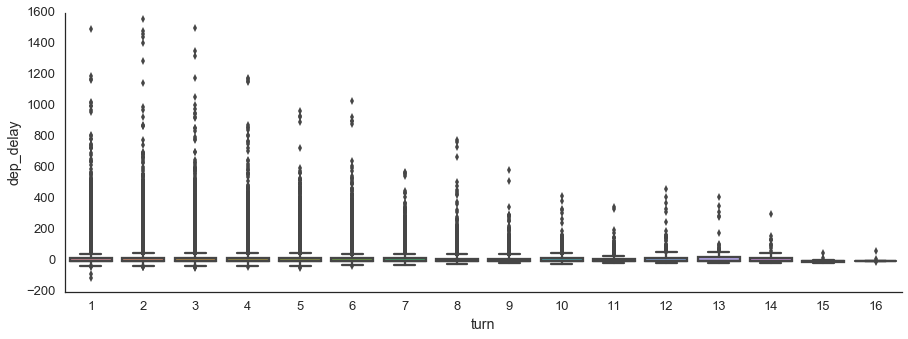

In [162]:
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay', 'distance']]
           .dropna()
           .sort_values('dep_time')
           .assign(turn = lambda x:
                x.groupby(['fl_date', 'tail_num'])
                 .dep_time
                 .transform('rank').astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax)
sns.despine()
plt.savefig('../content/images/mc_turn.svg', transparent=True)

Do flights later in the day have longer delays?

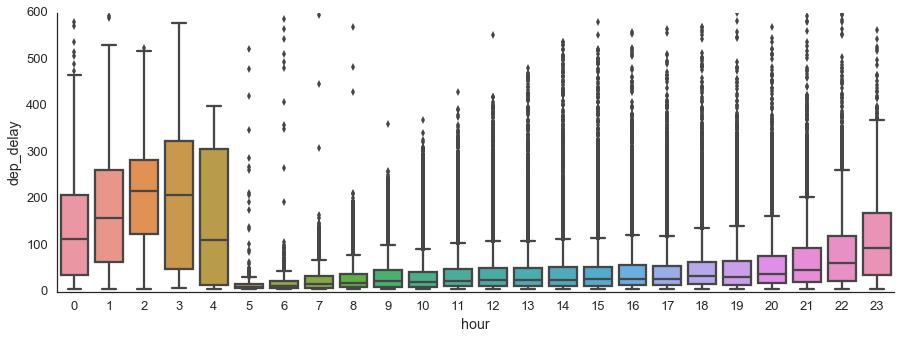

In [180]:
plt.figure(figsize=(15, 5))
(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay', 'distance']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay'))
sns.despine()
plt.savefig('../content/images/delay_by_hour.svg', transparent=True)

Let's call everyone above 10 hours an outlier and throw them out.

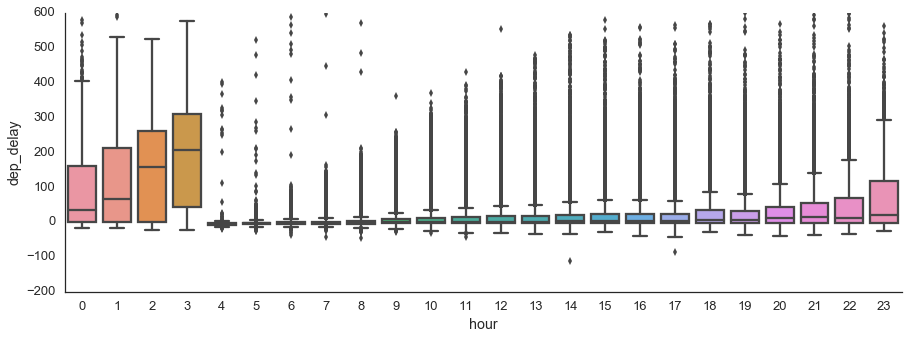

In [164]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='hour', y='dep_delay', data=flights[flights.dep_delay < 600], ax=ax)
sns.despine()
plt.savefig('../content/images/mc_no_days.svg', transparent=True)

Let's condition on there being a delay at all.

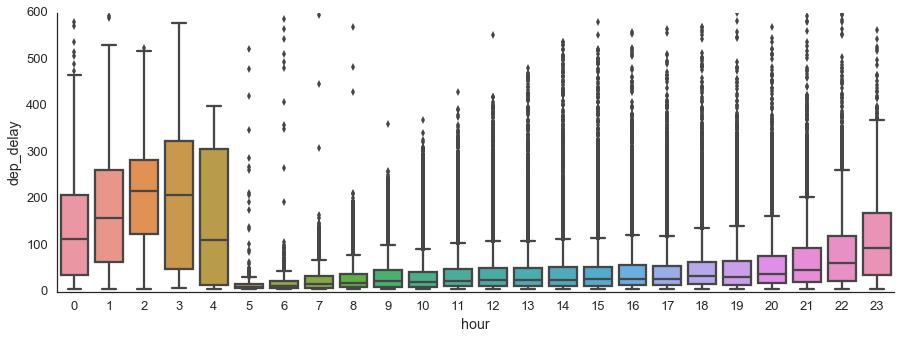

In [166]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='hour', y='dep_delay', data=flights.query('5 < dep_delay < 600'), ax=ax)
sns.despine()
plt.savefig('../content/images/mc_delays.svg', transparent=True)

Which flights are the worst?

In [175]:
# Groupby.agg accepts dict of {column: {ouput_name: agg_func}}
air = (df.groupby(['origin', 'dest'])
         .agg({'dep_delay': {'dep_mean': 'mean', 'dep_count': 'count'},
               'arr_delay': {'arr_mean': 'mean', 'arr_count': 'count'}}))
air.columns = air.columns.droplevel()

In [171]:
air[air.arr_count > 50].sort_values('dep_mean', ascending=False).head(10)

,,arr_mean,arr_count,dep_count,dep_mean
origin,dest,,,,
MDW,MSY,47.740741,54,54,55.111111
ORD,HSV,56.578125,64,65,52.800000
IAD,EWR,47.887500,80,81,52.333333
JFK,ATL,49.647887,142,142,51.464789
CMH,MIA,54.000000,61,61,51.344262
FLL,BOS,40.033784,148,148,51.033784
IAD,CLT,51.111111,54,54,50.888889
MDW,BDL,45.807692,52,52,50.442308
SJU,BOS,32.081081,111,112,49.660714


Which airlines are the worst?

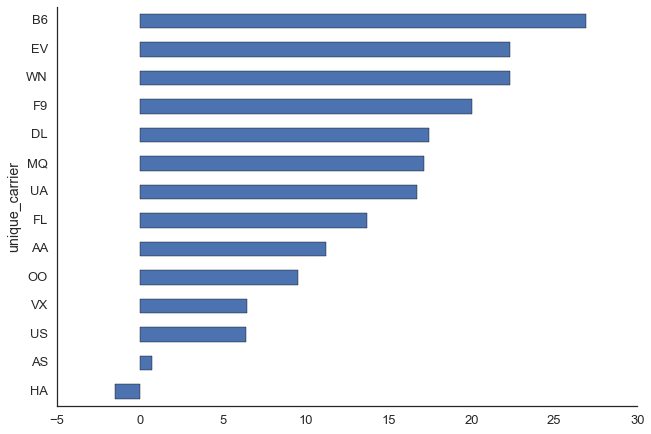

In [174]:
airlines = df.groupby('unique_carrier').dep_delay.agg(['mean', 'count'])
airlines['mean'].sort_values().plot.barh()
sns.despine()

B6 is Jet Blue.

I wanted to try out scikit-learn's [new Gaussian Process module](http://scikit-learn.org/dev/modules/gaussian_process.html) so here's a pretty picture.

In [192]:
print(delay.head().to_html())

<table border="0" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
      <th>delay</th>
      <th>dist</th>
    </tr>
    <tr>
      <th>tail_num</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>D942DN</th>
      <td>120</td>
      <td>9.232143</td>
      <td>829.783333</td>
    </tr>
    <tr>
      <th>N001AA</th>
      <td>139</td>
      <td>13.818182</td>
      <td>616.043165</td>
    </tr>
    <tr>
      <th>N002AA</th>
      <td>135</td>
      <td>9.570370</td>
      <td>570.377778</td>
    </tr>
    <tr>
      <th>N003AA</th>
      <td>125</td>
      <td>5.722689</td>
      <td>641.184000</td>
    </tr>
    <tr>
      <th>N004AA</th>
      <td>138</td>
      <td>2.037879</td>
      <td>630.391304</td>
    </tr>
  </tbody>
</table>


In [190]:
planes = df.assign(year=df.fl_date.dt.year).groupby("tail_num")
delay = (planes.agg({"year": "count",
                     "distance": "mean",
                     "arr_delay": "mean"})
               .rename(columns={"distance": "dist",
                                "arr_delay": "delay",
                                "year": "count"})
               .query("count > 20 & dist < 2000"))
delay.head()

,count,delay,dist
tail_num,,,
D942DN,120,9.232143,829.783333
N001AA,139,13.818182,616.043165
N002AA,135,9.570370,570.377778
N003AA,125,5.722689,641.184000
N004AA,138,2.037879,630.391304


In [253]:
X = delay['dist']
y = delay['delay']

In [254]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = (1.0 * RBF(length_scale=10.0, length_scale_bounds=(1e2, 1e4))
    + WhiteKernel(noise_level=.5, noise_level_bounds=(1e-1, 1e+5)))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X.reshape(-1, 1), y)

X_ = np.linspace(X.min(), X.max(), 1000)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

In [255]:
%matplotlib inline
sns.set(style='white', context='talk')

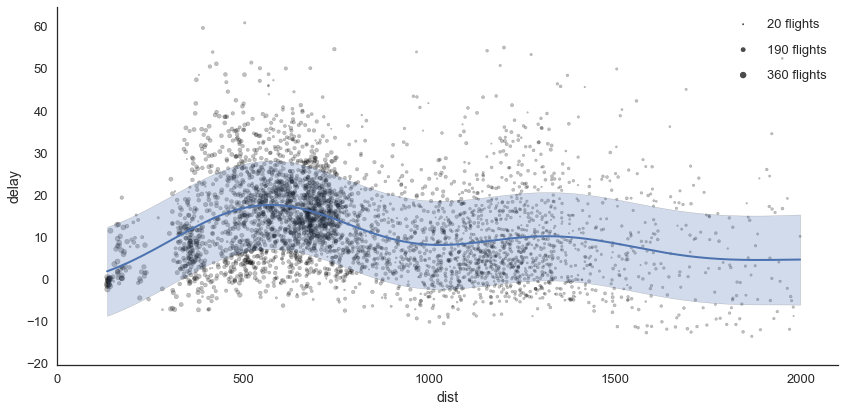

In [256]:
ax = delay.plot(kind='scatter', x='dist', y = 'delay', figsize=(12, 6),
                color='k', alpha=.25, s=delay['count'] / 10)

ax.plot(X_, y_mean, lw=2, zorder=9)
ax.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                y_mean + np.sqrt(np.diag(y_cov)),
                alpha=0.25)

sizes = (delay['count'] / 10).round(0)

for area in np.linspace(sizes.min(), sizes.max(), 3).astype(int):
    plt.scatter([], [], c='k', alpha=0.7, s=area,
                label=str(area * 10) + ' flights')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

ax.set_xlim(0, 2100)
ax.set_ylim(-20, 65)
sns.despine()
plt.tight_layout()
plt.savefig("../content/images/mc_flights.svg", transparent=True)
plt.savefig("../content/images/mc_flights.png")

In [159]:
df.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_delay,cancelled,cancellation_code,diverted,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2014-01-01,AA,19805,N338AA,1,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,AA,19805,N339AA,2,12892,1289203,32575,LAX,Los Angeles,...,111.0,0.0,NaN,0.0,2475.0,111.0,0.0,0.0,0.0,0.0
2,2014-01-01,AA,19805,N335AA,3,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,AA,19805,N367AA,5,11298,1129803,30194,DFW,Dallas/Fort Worth,...,1.0,0.0,NaN,0.0,3784.0,NaN,NaN,NaN,NaN,NaN
4,2014-01-01,AA,19805,N364AA,6,13830,1383002,33830,OGG,Kahului,...,-8.0,0.0,NaN,0.0,3711.0,NaN,NaN,NaN,NaN,NaN


Until next time.

In [193]:
import statsmodels.tsa.api as smt

In [197]:
jdaily = df.groupby('fl_date').dep_delay.mean().sort_index()

In [198]:
df.groupby(['origin', 'fl_date']).dep_delay.mean()

origin  fl_date   
ABE     2014-01-01     6.000000
        2014-01-02    -4.666667
        2014-01-03    -4.000000
        2014-01-04    19.000000
        2014-01-05    48.500000
                        ...    
YUM     2014-01-27    -7.111111
        2014-01-28    -6.714286
        2014-01-29     7.125000
        2014-01-30     3.777778
        2014-01-31    -2.888889
Name: dep_delay, dtype: float64

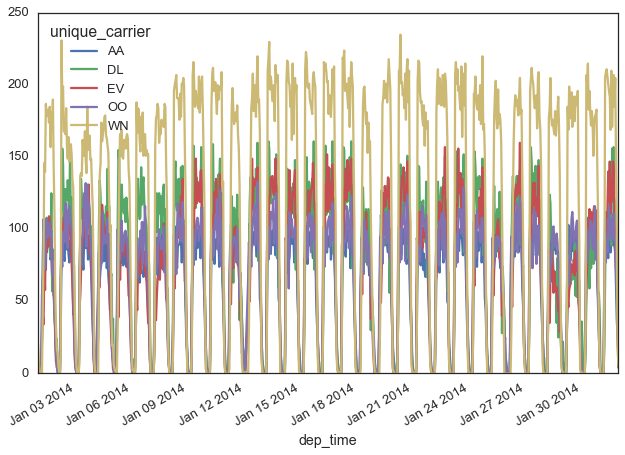

In [247]:
hourly = (
    df.dropna(subset=['dep_time', 'unique_carrier'])
      .loc[df['unique_carrier']
           .isin(df['unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   .groupby(['unique_carrier', pd.TimeGrouper("H")])
   .fl_num.count()
   .unstack(0).fillna(0).plot())

In [250]:
sns.set_style('ticks')

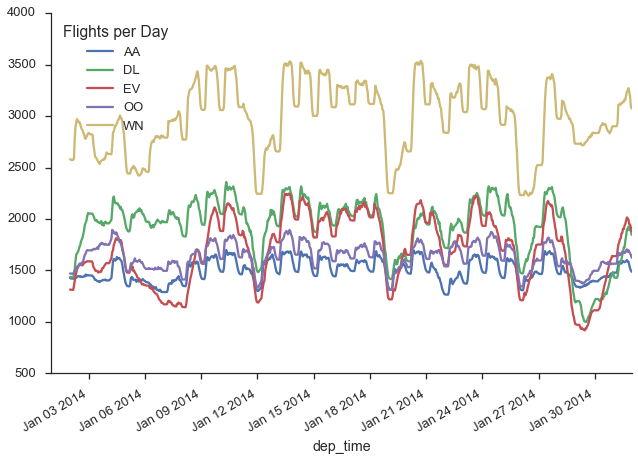

In [251]:
(df.dropna(subset=['dep_time', 'unique_carrier'])
   .loc[df['unique_carrier']
       .isin(df['unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   .groupby(['unique_carrier', pd.TimeGrouper("H")])
   .fl_num.count()
   .unstack(0)
   .fillna(0)
   .rolling(24)
   .sum()
   .rename_axis("Flights per Day", axis=1)
   .plot()
)
sns.despine()
plt.savefig("../content/images/flights_per_day.svg", transparent=True)

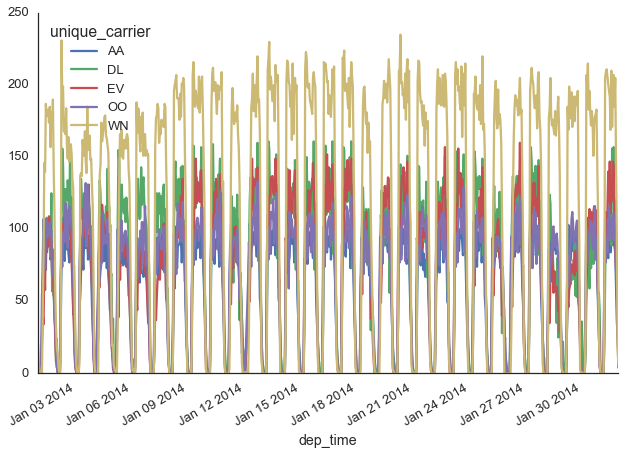

In [235]:
hourly.unstack(0).fillna(0).plot()
sns.despine()k

In [229]:
top = hourly.index.get_level_values('unique_carrier').value_counts().index[:5]

In [222]:
gr.fl_num.count().index.get_level_values(0).value_counts().sort_values()

F9    533
VX    555
MQ    589
WN    605
FL    612
     ... 
DL    662
UA    667
US    673
AS    689
B6    697
dtype: int64

In [215]:
gr.unstack()

unique_carrier  dep_time           
AA              2014-01-01 00:00:00      8
                2014-01-01 01:00:00      1
                2014-01-01 05:00:00     31
                2014-01-01 06:00:00     77
                2014-01-01 07:00:00    107
                                      ... 
WN              2014-01-31 19:00:00    205
                2014-01-31 20:00:00    147
                2014-01-31 21:00:00     98
                2014-01-31 22:00:00     18
                2014-01-31 23:00:00      6
Name: fl_num, dtype: int64

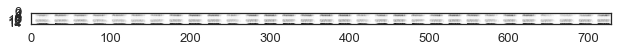

In [214]:
gr.unstack(1).fillna(0).pipe(p)

In [206]:
df.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_delay,cancelled,cancellation_code,diverted,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2014-01-01,AA,19805,N338AA,1,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,AA,19805,N339AA,2,12892,1289203,32575,LAX,Los Angeles,...,111.0,0.0,NaN,0.0,2475.0,111.0,0.0,0.0,0.0,0.0
2,2014-01-01,AA,19805,N335AA,3,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,AA,19805,N367AA,5,11298,1129803,30194,DFW,Dallas/Fort Worth,...,1.0,0.0,NaN,0.0,3784.0,NaN,NaN,NaN,NaN,NaN
4,2014-01-01,AA,19805,N364AA,6,13830,1383002,33830,OGG,Kahului,...,-8.0,0.0,NaN,0.0,3711.0,NaN,NaN,NaN,NaN,NaN


In [201]:
gr = df.set_index(['dep_time']).groupby(['unique_carrier', pd.TimeGrouper("Min")])

IndexError: index 441740 is out of bounds for size 441586

In [ ]:
smt.seasonal_decompose()